<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihoodTestingVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     - 10.8MB 1.2MB/s


In [0]:
import corner

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [0]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,784,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)



# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)

# do VI on corrupted data
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)

sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001
approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')


#mean can be used as starting point for MAP minimization
elbo_mean         = approx_posterior_elbo.mean()


zz_               = approx_posterior_elbo.sample()
kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
elbo_liklogits    = tf.reshape(generator(zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

# likelihood of posterior mean
mu_liklogits          = tf.reshape(generator(mu_elbo),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(approx_posterior_elbo.sample(sample_size_z),[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()




#### for naive recon and strating MAP finding at truth
nvp_prior            = tf.placeholder_with_default(True,shape=[])

### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,784,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])



##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)



# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only teh diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

# # # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = gmm.sample(sample_size_z)
# #gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

# saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:47.333901 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:47.379740 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:47.452842 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:48.412449 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:48.530619 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:48.849284 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:48.932249 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:49.202846 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:49.284190 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:49.330615 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:52.602203 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0510 01:22:52.713929 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


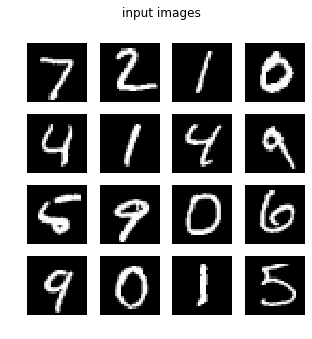

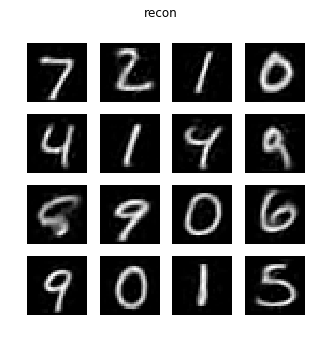

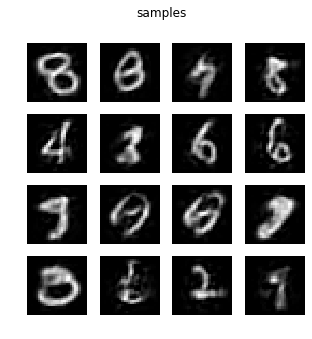

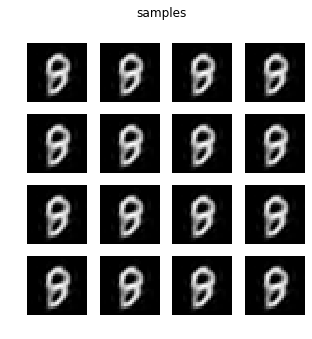

In [0]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
nvp_loss = []
ii     = 0
nepoch = 0
learning_rate = 1e-3

In [0]:
#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    np.random.shuffle(x_train)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>10:
    learning_rate=1e-5
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  nvp_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

In [0]:
plt.figure()
plot(nvp_loss[::],label='nvp loss')
legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 23:26:00.653257 139827474454400 saver.py:1483] Saver not created because there are no variables in the graph to restore


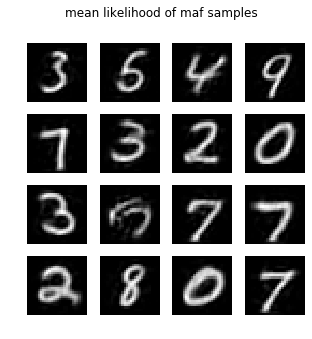

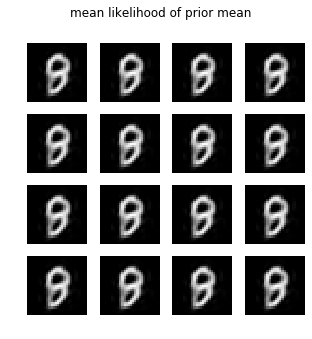

In [0]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [0]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 16:12:58.223864 140394039564160 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


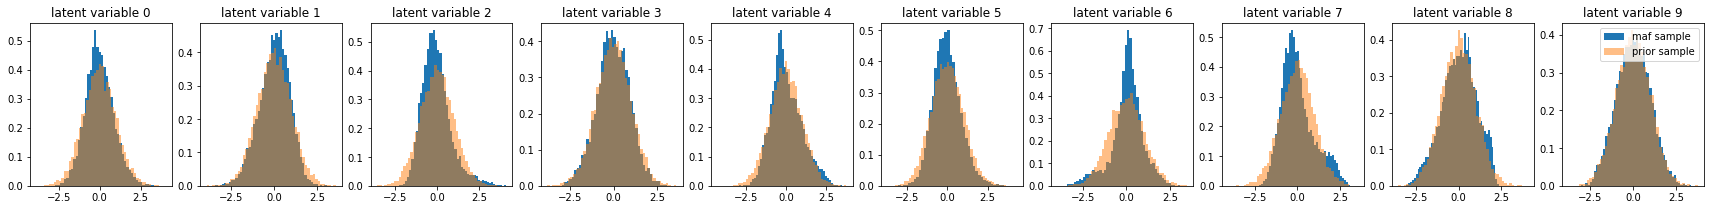

In [0]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

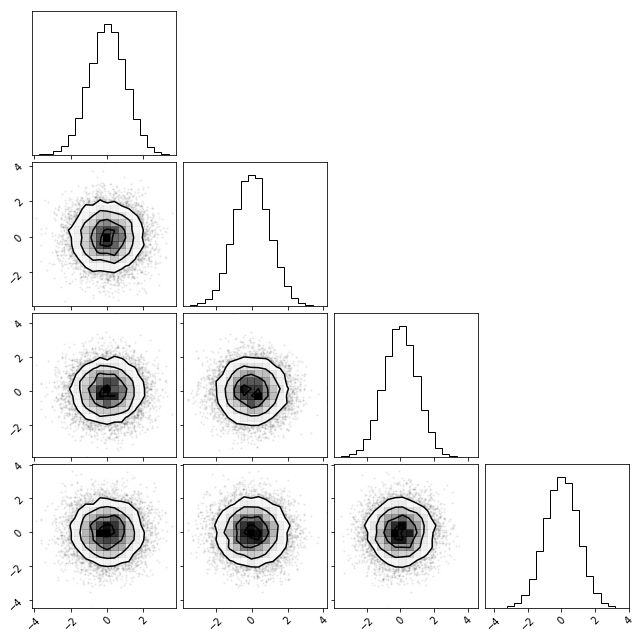

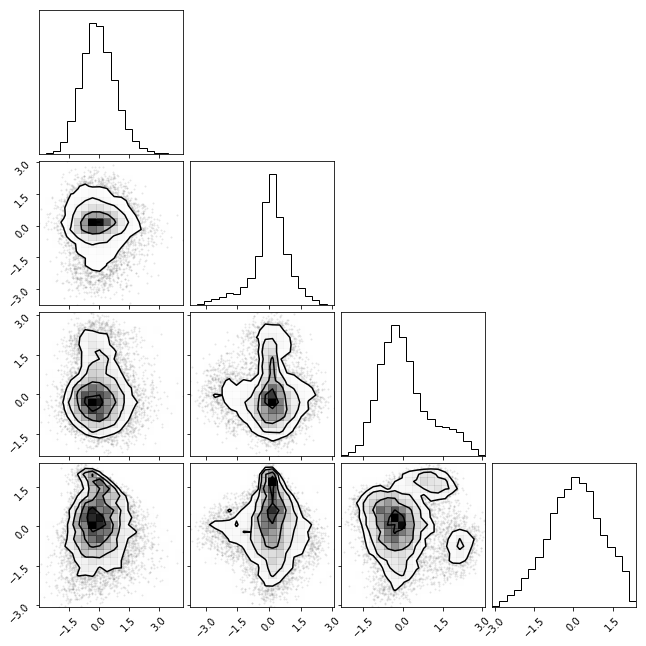

In [0]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

**Make corrupted data**

In [0]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
mask[0:28,12:18]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)
#mask = np.expand_dims(mask, -1)
data = np.expand_dims(masked_data,-1)

**Minimize ELBO for corrupted data and look at samples**

In [0]:
posterior_loss=[]

In [0]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

745.89435
745.2322
742.9766
750.56134
749.3739
743.60706
747.53217
746.7559
744.4076
743.3602
746.89355
746.699
757.9926
748.72565
748.80975
748.34015
743.65485
743.3957
744.7739
749.0084


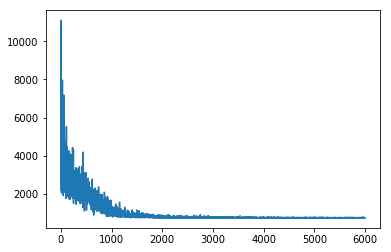

In [0]:
plt.plot(posterior_loss)

In [0]:
mean = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new})
print(samples.shape)

(1, 64, 784, 1)


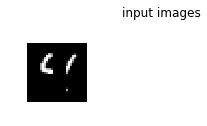

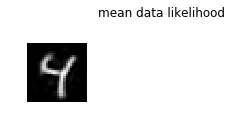

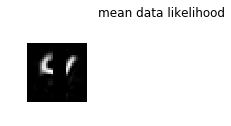

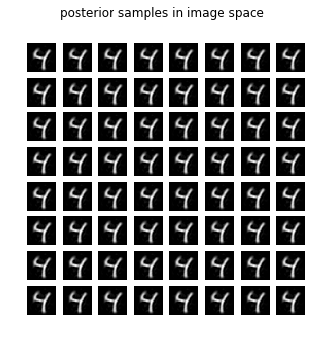

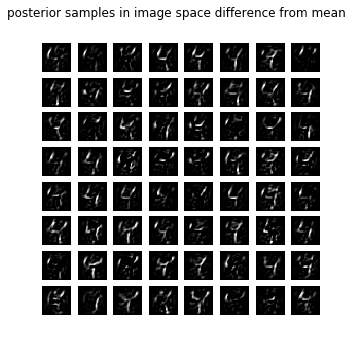

In [0]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()

**find minima with nvp**

0
2218.6267
768.0204
737.0927
745.9061
737.3589
737.2671
737.3633
737.5728
738.7763
737.76276
switching to lr 0.01
737.2991
737.2617
737.2614
737.2656
737.26483
switching to lr 0.001
737.28174
737.2615
1
1876.9152
1946.1229
744.992
737.35065
737.4235
737.93774
737.4944
737.418
737.27844
737.27344
switching to lr 0.01
737.5062
737.2729
737.26953
737.26575
737.2671
switching to lr 0.001
737.26935
737.26544
2
5517.596
1944.7792
1944.6757
1944.6664
1945.2799
1811.7018
1814.3348
1812.1123
1809.719
1814.0934
switching to lr 0.01
1810.3241
1808.8208
1808.8063
1808.924
1808.8934
switching to lr 0.001
1809.3088
1808.7032
3
2257.2498
1151.3411
1078.0709
1078.1417
1078.3007
1077.5834
1081.1357
1080.5375
1077.4972
1078.1813
switching to lr 0.01
1078.5443
1078.0433
1078.0691
1078.1316
1078.1462
switching to lr 0.001
1078.0925
1078.0293
4
2273.408
1078.9899
1094.6633
737.269
748.1318
737.3591
739.2775
737.283
737.2656
753.1836
switching to lr 0.01
744.67664
737.35175
737.3334
737.32166
737.2672
swit

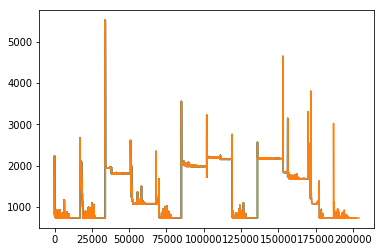

In [0]:
posterior_corr_loss=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_corr_loss,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]

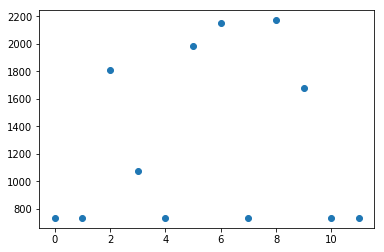

In [0]:
plt.figure()
plt.plot(np.arange(12),l_minima,ls='',marker='o')
plt.show()

In [0]:
import pickle
#pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima.pkl','wb'))
l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima.pkl','rb'))

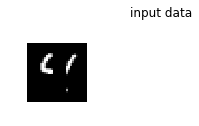

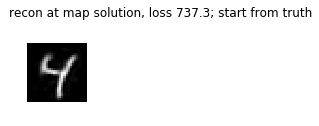

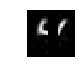

eigenvalues before and after inverse, approx hessian
[array([[9.9444824e-01, 9.9895227e-01, 9.9984193e-01, 9.9995369e-01,
        1.0000000e+00, 1.0000017e+00, 1.0000556e+00, 1.0006843e+00,
        1.0509987e+00, 3.2389725e+05]], dtype=float32), array([[3.08739881e-06, 9.93698863e-01, 9.99896825e-01, 9.99955288e-01,
        9.99992469e-01, 9.99999928e-01, 1.00000828e+00, 1.00027347e+00,
        1.00061535e+00, 1.00465241e+00]])]


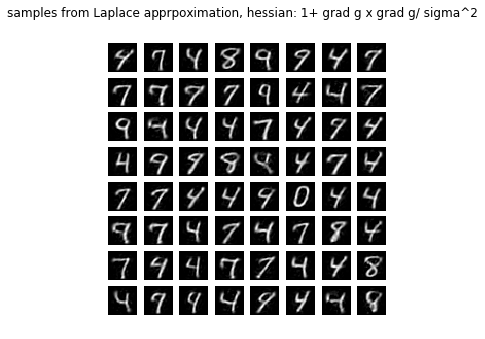

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9444824e-01, 9.9895227e-01, 9.9984193e-01, 9.9995369e-01,
        1.0000000e+00, 1.0000017e+00, 1.0000556e+00, 1.0006843e+00,
        1.0509987e+00, 3.2389725e+05]], dtype=float32), array([[3.08739881e-06, 9.93698863e-01, 9.99896825e-01, 9.99955288e-01,
        9.99992469e-01, 9.99999928e-01, 1.00000828e+00, 1.00027347e+00,
        1.00061535e+00, 1.00465241e+00]])]


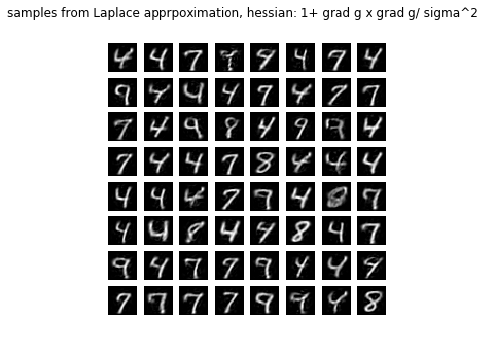

covariances
(1, 10, 10)


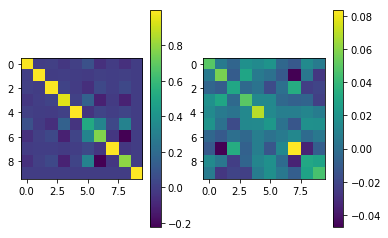

hessians
(1, 10, 10)


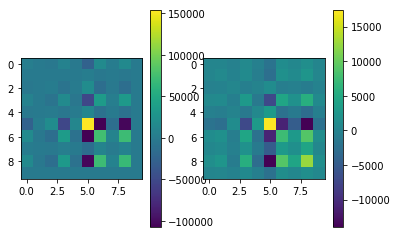

eigenvalues before and after inverse, full hessian
[array([[6.2457314e+00, 8.9888916e+00, 1.0649131e+01, 2.2095978e+01,
        3.7923798e+01, 2.2422910e+02, 5.1254156e+02, 7.6117059e+02,
        1.2909111e+03, 4.2005867e+04]], dtype=float32), array([[2.38062029e-05, 7.74645909e-04, 1.31376590e-03, 1.95106319e-03,
        4.45972284e-03, 2.63686938e-02, 4.52572273e-02, 9.39011254e-02,
        1.11236360e-01, 1.60112547e-01]])]
10


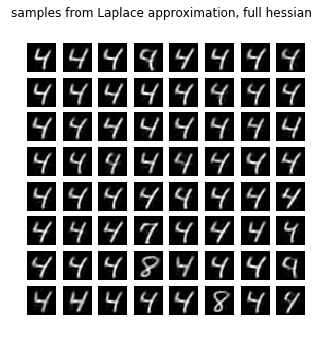

1


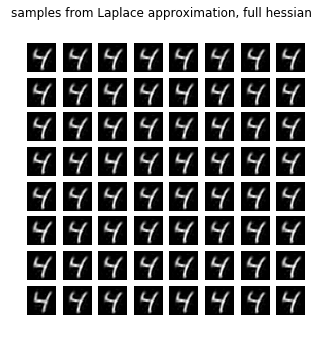

1e-32


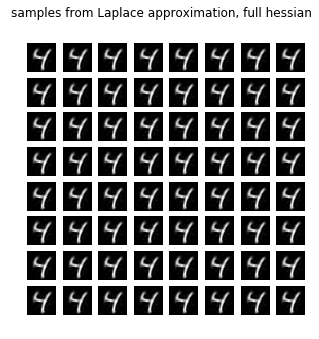

diagonal approx


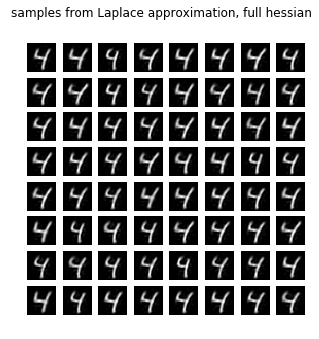

3489.1082
2412.841
2277.103
1684.5502
2282.3647
2104.1328
1305.3295
2012.8762
1254.5614
1444.0354
1588.0234
877.7021
901.3866
825.5091
995.14417
804.47943
834.858
822.7101
797.3865
748.7554


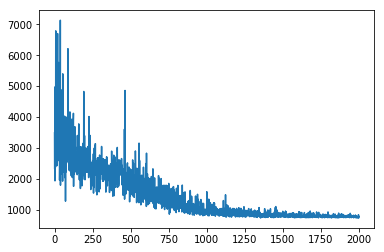

variance of VI [[0.08888435 0.11309123 0.09636202 0.12024885 0.08191095 0.13721748
  0.09400298 0.06454715 0.07174703 0.10019065]]


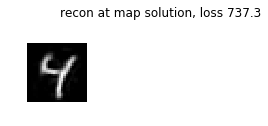

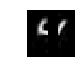

eigenvalues before and after inverse, approx hessian
[array([[9.9632251e-01, 9.9959874e-01, 9.9982876e-01, 9.9996895e-01,
        9.9999821e-01, 1.0000390e+00, 1.0001390e+00, 1.0003334e+00,
        1.0004786e+00, 1.6094714e+05]], dtype=float32), array([[6.21321997e-06, 9.99288890e-01, 9.99780895e-01, 9.99902522e-01,
        9.99978840e-01, 9.99993778e-01, 1.00003727e+00, 1.00017057e+00,
        1.00041606e+00, 1.00277461e+00]])]


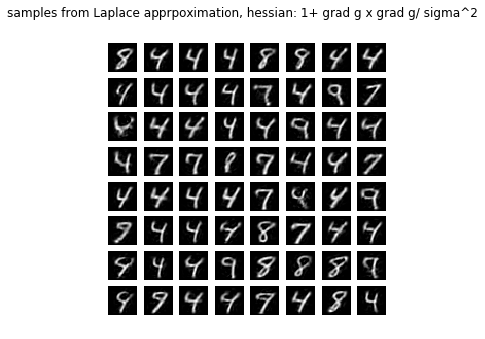

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9632251e-01, 9.9959874e-01, 9.9982876e-01, 9.9996895e-01,
        9.9999821e-01, 1.0000390e+00, 1.0001390e+00, 1.0003334e+00,
        1.0004786e+00, 1.6094714e+05]], dtype=float32), array([[6.21321997e-06, 9.99288890e-01, 9.99780895e-01, 9.99902522e-01,
        9.99978840e-01, 9.99993778e-01, 1.00003727e+00, 1.00017057e+00,
        1.00041606e+00, 1.00277461e+00]])]


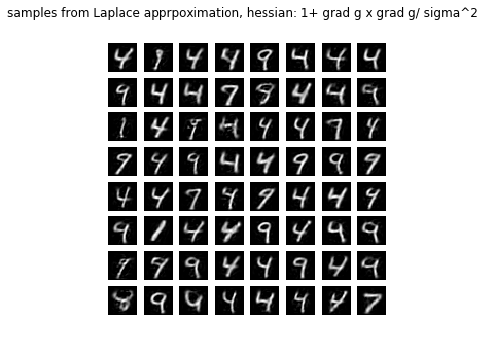

covariances
(1, 10, 10)


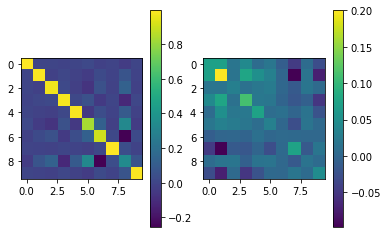

hessians
(1, 10, 10)


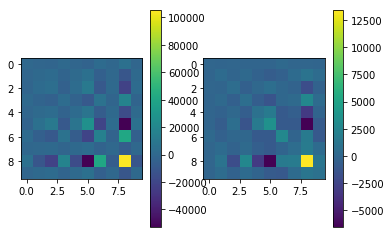

eigenvalues before and after inverse, full hessian
[array([[2.6885281e+00, 9.9899445e+00, 1.1794541e+01, 1.4498813e+01,
        3.3006798e+01, 2.2949454e+02, 3.6716714e+02, 8.8987817e+02,
        3.4477505e+03, 1.8927902e+04]], dtype=float32), array([[5.28320677e-05, 2.90044247e-04, 1.12374942e-03, 2.72354984e-03,
        4.35740602e-03, 3.02968606e-02, 6.89700503e-02, 8.47827130e-02,
        1.00100016e-01, 3.71944060e-01]])]
10


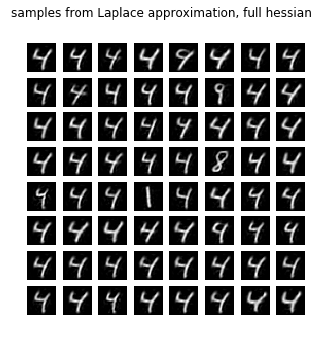

1


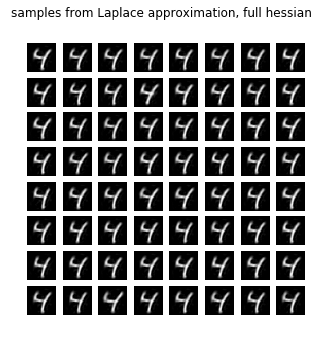

1e-32


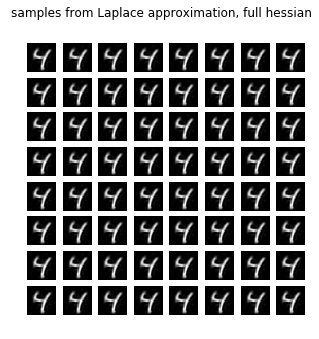

diagonal approx


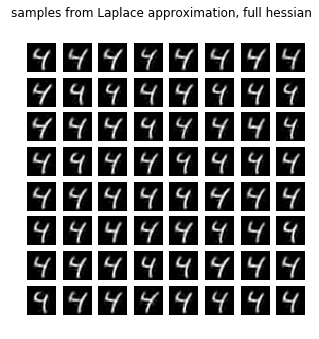

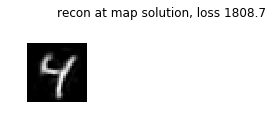

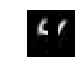

eigenvalues before and after inverse, approx hessian
[array([[9.9892646e-01, 9.9975812e-01, 9.9995041e-01, 9.9998999e-01,
        1.0000136e+00, 1.0001178e+00, 1.0001569e+00, 1.0005001e+00,
        1.0033886e+00, 1.7955016e+05]], dtype=float32), array([[5.56947486e-06, 9.98777775e-01, 9.99609437e-01, 9.99909646e-01,
        9.99975802e-01, 1.00000495e+00, 1.00001972e+00, 1.00010130e+00,
        1.00024494e+00, 1.00128688e+00]])]


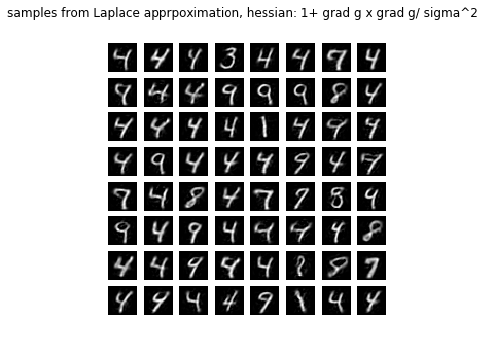

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9892646e-01, 9.9975812e-01, 9.9995041e-01, 9.9998999e-01,
        1.0000136e+00, 1.0001178e+00, 1.0001569e+00, 1.0005001e+00,
        1.0033886e+00, 1.7955016e+05]], dtype=float32), array([[5.56947486e-06, 9.98777775e-01, 9.99609437e-01, 9.99909646e-01,
        9.99975802e-01, 1.00000495e+00, 1.00001972e+00, 1.00010130e+00,
        1.00024494e+00, 1.00128688e+00]])]


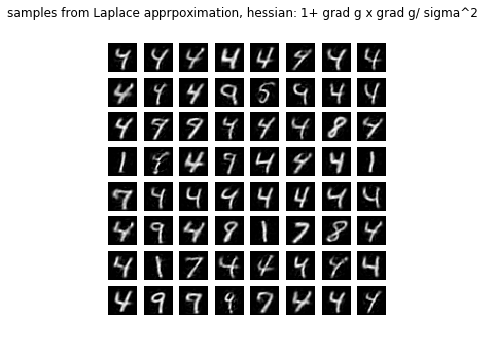

covariances
(1, 10, 10)


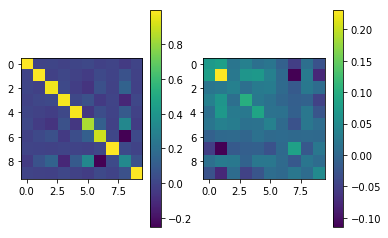

hessians
(1, 10, 10)


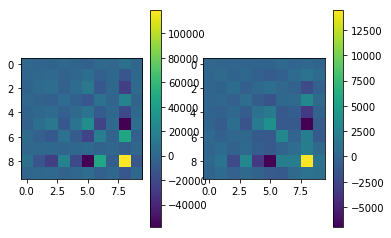

eigenvalues before and after inverse, full hessian
[array([[2.4472482e+00, 8.9646435e+00, 1.0640954e+01, 1.4398180e+01,
        3.3012722e+01, 2.1850317e+02, 3.6969562e+02, 8.8956628e+02,
        3.4595830e+03, 2.0458125e+04]], dtype=float32), array([[4.88803175e-05, 2.89051964e-04, 1.12414361e-03, 2.70493190e-03,
        4.57659092e-03, 3.02910807e-02, 6.94533081e-02, 9.39842032e-02,
        1.11558213e-01, 4.08640761e-01]])]
10


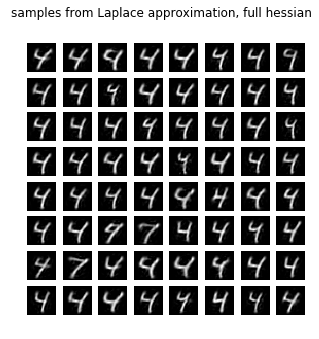

1


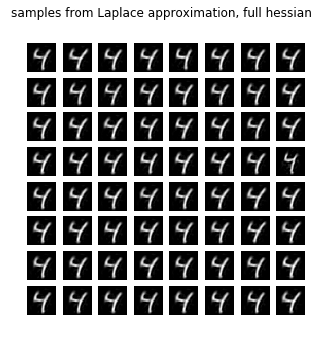

1e-32


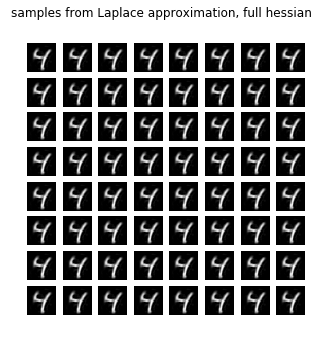

diagonal approx


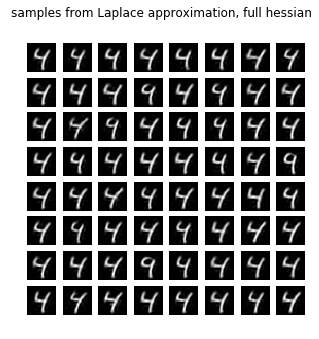

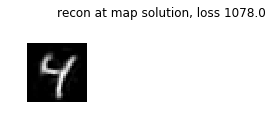

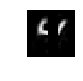

eigenvalues before and after inverse, approx hessian
[array([[9.9080980e-01, 9.9932158e-01, 9.9984872e-01, 9.9997258e-01,
        9.9999934e-01, 1.0000331e+00, 1.0001043e+00, 1.0002893e+00,
        1.0006311e+00, 1.7956216e+05]], dtype=float32), array([[5.56910233e-06, 9.99036020e-01, 9.99559669e-01, 9.99931174e-01,
        9.99978440e-01, 9.99996733e-01, 1.00001786e+00, 1.00017765e+00,
        1.00062111e+00, 1.00278325e+00]])]


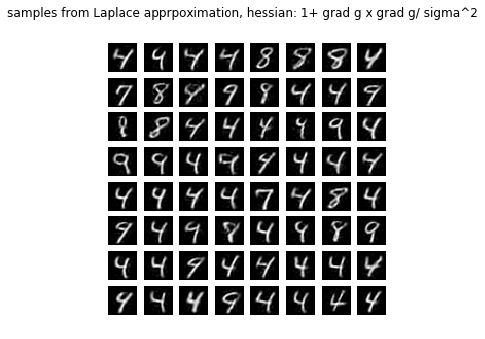

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9080980e-01, 9.9932158e-01, 9.9984872e-01, 9.9997258e-01,
        9.9999934e-01, 1.0000331e+00, 1.0001043e+00, 1.0002893e+00,
        1.0006311e+00, 1.7956216e+05]], dtype=float32), array([[5.56910233e-06, 9.99036020e-01, 9.99559669e-01, 9.99931174e-01,
        9.99978440e-01, 9.99996733e-01, 1.00001786e+00, 1.00017765e+00,
        1.00062111e+00, 1.00278325e+00]])]


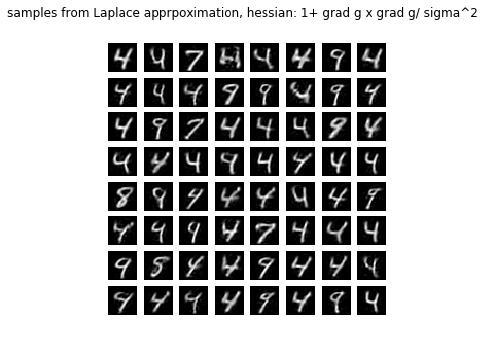

covariances
(1, 10, 10)


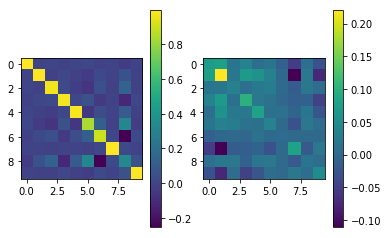

hessians
(1, 10, 10)


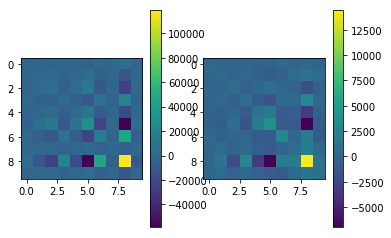

eigenvalues before and after inverse, full hessian
[array([[2.5582781e+00, 9.1511707e+00, 1.0874075e+01, 1.4283315e+01,
        3.2923347e+01, 2.1868459e+02, 3.7128967e+02, 8.8878510e+02,
        3.4620415e+03, 2.0439531e+04]], dtype=float32), array([[4.89247878e-05, 2.88846990e-04, 1.12513061e-03, 2.69331156e-03,
        4.57279880e-03, 3.03736086e-02, 7.00120973e-02, 9.19595117e-02,
        1.09274821e-01, 3.90855826e-01]])]
10


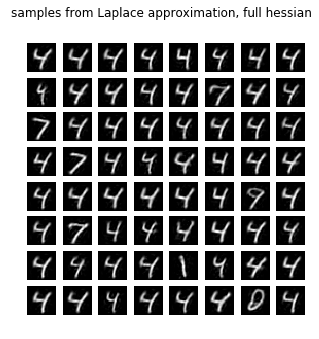

1


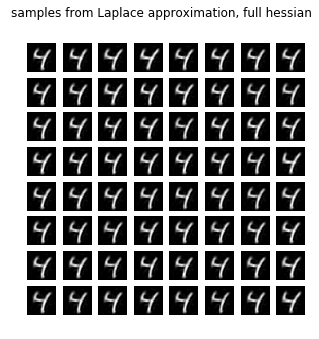

1e-32


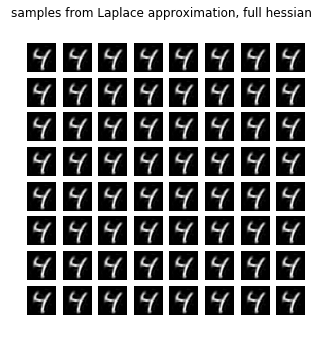

diagonal approx


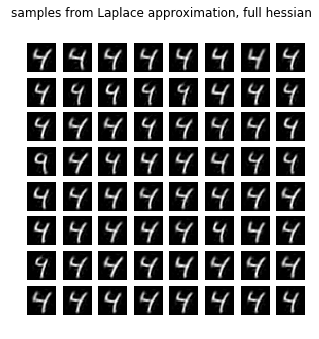

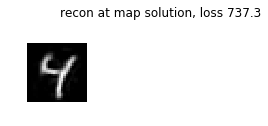

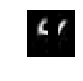

eigenvalues before and after inverse, approx hessian
[array([[9.9004114e-01, 9.9962366e-01, 9.9976170e-01, 9.9995732e-01,
        1.0000052e+00, 1.0000533e+00, 1.0001277e+00, 1.0009273e+00,
        1.0042804e+00, 2.0872817e+05]], dtype=float32), array([[4.79091886e-06, 9.96567275e-01, 9.99440084e-01, 9.99881413e-01,
        9.99974849e-01, 1.00000849e+00, 1.00005749e+00, 1.00013401e+00,
        1.00046705e+00, 1.00160452e+00]])]


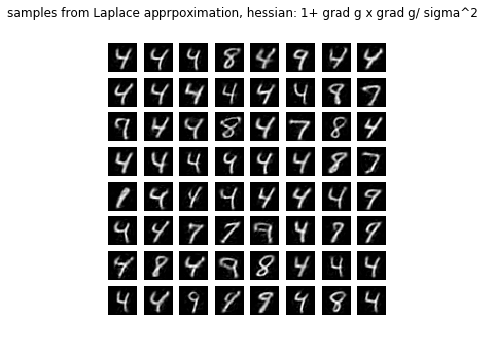

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9004114e-01, 9.9962366e-01, 9.9976170e-01, 9.9995732e-01,
        1.0000052e+00, 1.0000533e+00, 1.0001277e+00, 1.0009273e+00,
        1.0042804e+00, 2.0872817e+05]], dtype=float32), array([[4.79091886e-06, 9.96567275e-01, 9.99440084e-01, 9.99881413e-01,
        9.99974849e-01, 1.00000849e+00, 1.00005749e+00, 1.00013401e+00,
        1.00046705e+00, 1.00160452e+00]])]


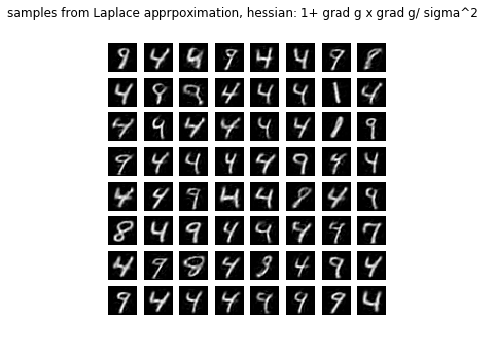

covariances
(1, 10, 10)


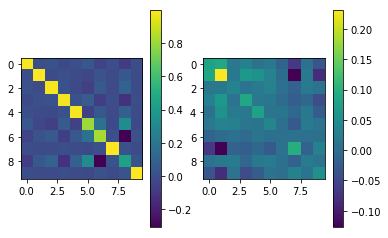

hessians
(1, 10, 10)


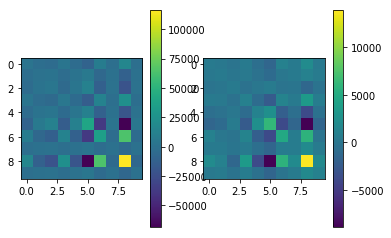

eigenvalues before and after inverse, full hessian
[array([[2.39045572e+00, 9.93616962e+00, 1.05157709e+01, 1.53282671e+01,
        3.03110523e+01, 2.15554062e+02, 3.28996826e+02, 1.01283746e+03,
        3.00515576e+03, 2.55608008e+04]], dtype=float32), array([[3.91224152e-05, 3.32761337e-04, 9.87324919e-04, 3.03954196e-03,
        4.63919164e-03, 3.29914779e-02, 6.52381316e-02, 9.50964267e-02,
        1.00643173e-01, 4.18353094e-01]])]
10


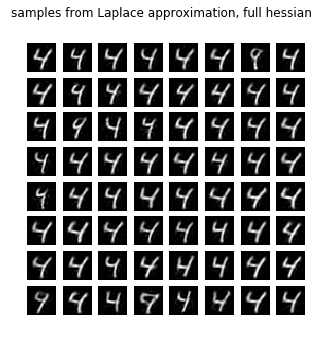

1


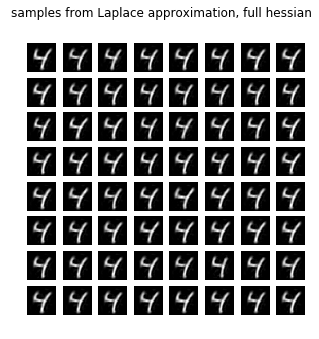

1e-32
full hessian fails


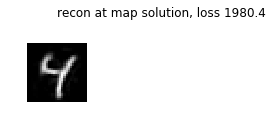

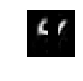

eigenvalues before and after inverse, approx hessian
[array([[9.9896514e-01, 9.9974680e-01, 9.9987948e-01, 9.9998772e-01,
        1.0000182e+00, 1.0001029e+00, 1.0003299e+00, 1.0007063e+00,
        1.0059874e+00, 1.8652683e+05]], dtype=float32), array([[5.36116046e-06, 9.97012591e-01, 9.99155677e-01, 9.99658189e-01,
        9.99872317e-01, 9.99954547e-01, 1.00001030e+00, 1.00006172e+00,
        1.00018976e+00, 1.00040180e+00]])]


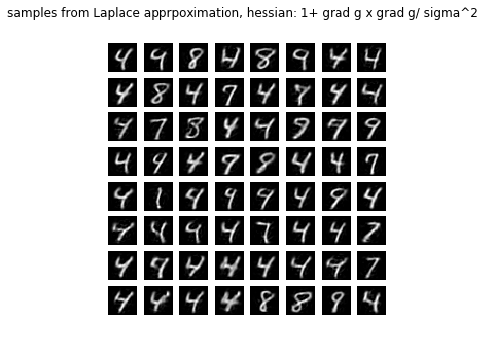

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9896514e-01, 9.9974680e-01, 9.9987948e-01, 9.9998772e-01,
        1.0000182e+00, 1.0001029e+00, 1.0003299e+00, 1.0007063e+00,
        1.0059874e+00, 1.8652683e+05]], dtype=float32), array([[5.36116046e-06, 9.97012591e-01, 9.99155677e-01, 9.99658189e-01,
        9.99872317e-01, 9.99954547e-01, 1.00001030e+00, 1.00006172e+00,
        1.00018976e+00, 1.00040180e+00]])]


KeyboardInterrupt: ignored

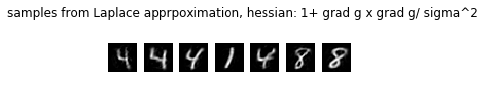

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
# order minima by loss function value
l_minima  = np.asarray(l_minima)
map_minima= np.asarray(map_minima)
order     = np.argsort(l_minima)

for ii,ini_ in enumerate(map_minima[order]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  print('diagonal approx')
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False, diag_hess:True})
  




  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [10,1,1e-32]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')

#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo_,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new})
    print('variance of VI', elbo_var)

(1, 10, 10)
126.57541582487691 302.18628 4217.847
78.18836683537216 771.1041 86.59863
107.6931885058842 399.1396 2420.9126
69.15732084968053 2908.19 17185.867
149.04455757023015 688.0281 1076.1974
53.11059180443996 17426.879 154028.7
113.1662134783013 7545.3413 75139.98
240.019120242949 1700.2384 1101.2837
194.2638923116034 12539.194 68647.81
99.61979372975401 600.31586 1.05746


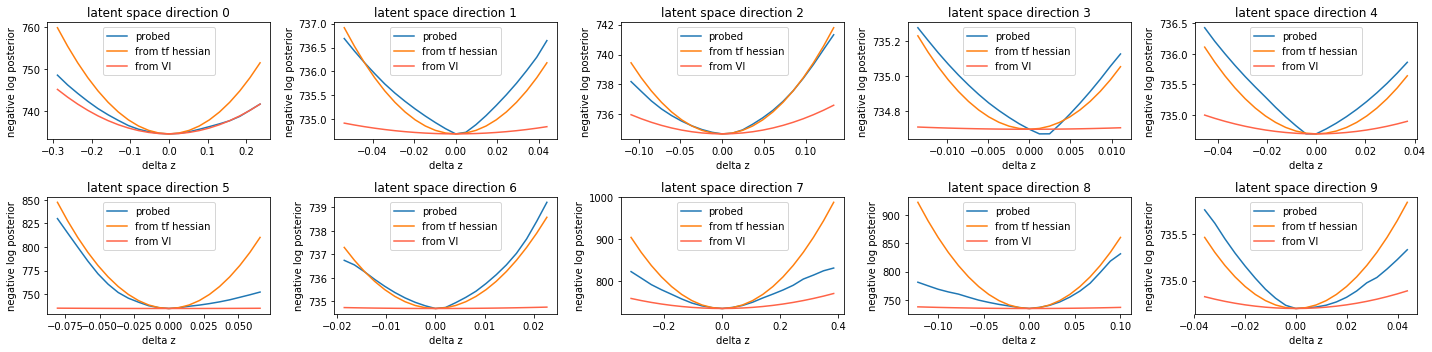

In [0]:
order     = np.argsort(l_minima)[0]

# testing Hessian
for ii,ini_ in enumerate([map_minima[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  print(GN_hessian.shape)
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    print(elbo_v,B, GN)
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from tf hessian')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


W0509 16:35:37.530491 140394039564160 legend.py:1289] No handles with labels found to put in legend.


(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)


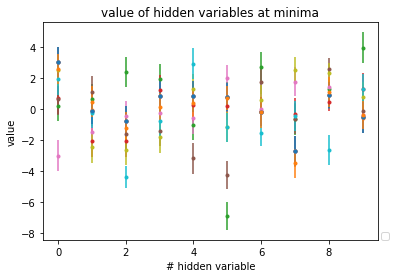

In [0]:
# varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**minima without nvp**

0
2510.781
715.8751
716.20795
715.74634
715.5261
715.5279
715.53986
715.5991
715.55994
715.5015
1
2552.6018
721.3948
721.2608
721.40186
721.2024
721.19336
721.2048
721.2475
721.2359
721.1782
2
3231.0293
715.4342
714.45703
714.3408
713.8618
713.9766
713.87634
713.87463
713.83026
713.7777
3
4125.0234
2062.8564
2062.7993
2064.1687
2062.1814
2062.1665
2062.1565
2061.9202
2061.9814
2061.8257
4
3884.3188
714.248
714.94403
715.1312
714.04083
714.12756
713.8223
714.0194
713.9085
713.77814
5
3424.9893
1504.9663
1504.74
1505.0208
1503.5886
1503.6027
1503.718
1503.7007
1503.5729
1503.3596
6
1971.1012
715.7565
715.57996
714.98456
714.0145
713.8299
713.91815
713.9369
713.9621
713.778
7
2411.3726
722.7253
722.851
722.7341
722.4623
722.4575
722.44116
722.4534
722.4699
722.4057
8
3186.693
863.875
863.9216
864.0499
863.82526
863.8361
863.8238
863.8463
863.8323
863.80444
9
6565.657
863.8622
863.93524
863.8541
863.8217
863.8338
863.8263
863.84125
863.8182
863.8042


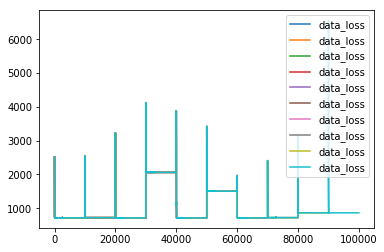

In [0]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

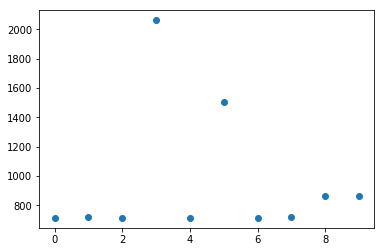

In [0]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [0]:
import pickle
#pickle.dump([l_minima_old,map_minima_old],open(minima_path+'minima_nonvp.pkl','wb'))
l_minima_old,map_minima_old = pickle.load(open(minima_path+'minima_nonvp.pkl','rb'))

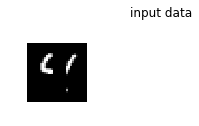

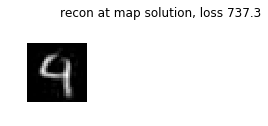

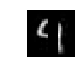

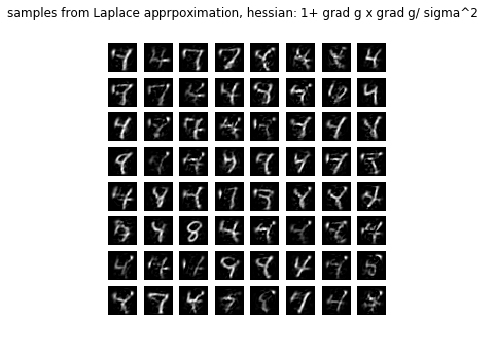

<Figure size 360x360 with 0 Axes>

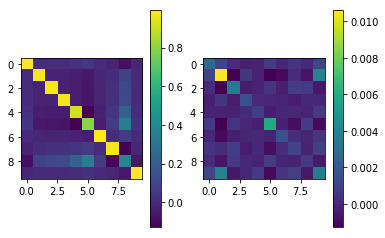

eigenvalues before and after inverse, full hessian
[array([[  74.718185,  160.16638 ,  233.34651 ,  296.10474 ,  524.5163  ,
         643.95294 ,  872.13574 , 1746.605   , 2714.48    , 5340.9385  ]],
      dtype=float32), array([[0.00018723, 0.00036839, 0.00057254, 0.00114661, 0.00155291,
        0.00190652, 0.00337718, 0.00428547, 0.00624351, 0.01338364]])]


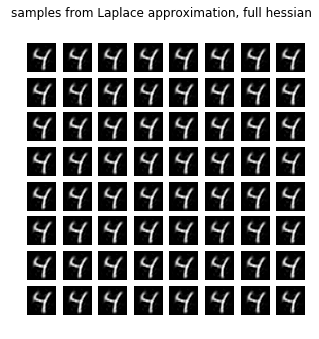

2550.0188
1071.6537
980.4719
968.22864
941.1387
760.45844
757.3877
741.61786
767.6763
788.5663
768.6877
747.7126
743.9709
760.5246
754.18256
741.35394
760.5341
749.6487
740.3836
742.80554


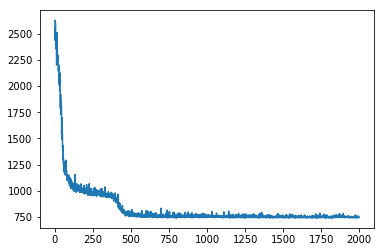

variance of VI [[-3.075445  -2.8460143 -3.053605  -3.1617608 -3.5042872 -2.582243
  -3.2028553 -3.6476161 -3.343648  -3.3109295]]


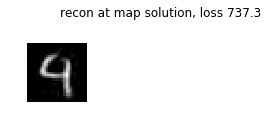

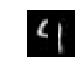

KeyboardInterrupt: ignored

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

#order minimia
varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)


for ii,ini_ in enumerate(map_minima_old[order]):
  
  # set MAP
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
 
  # Laplace approximation
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  #mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))

  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
    
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
    print('variance of VI', elbo_var)    


(1, 10, 10)


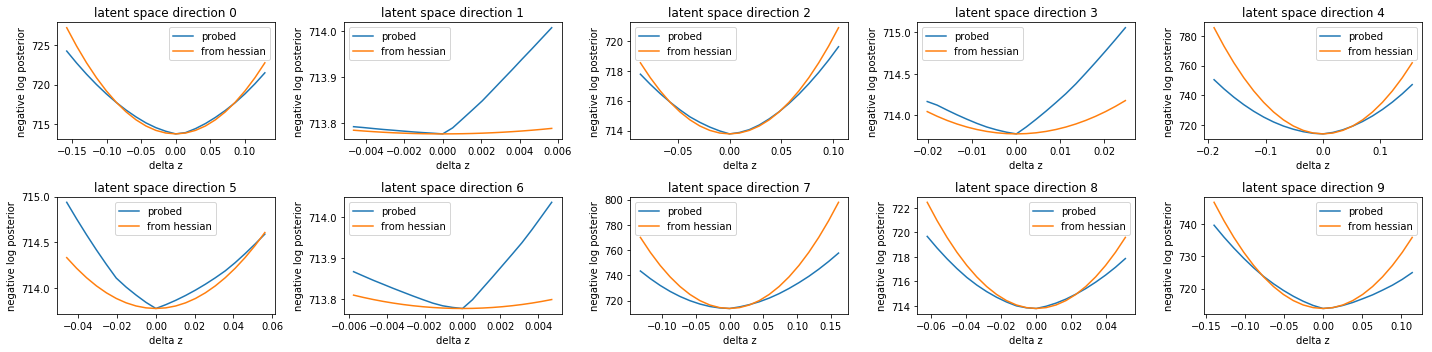

In [0]:
order     = np.argsort(l_minima_old)[0]
# testing Hessian
for ii,ini_ in enumerate([map_minima_old[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True, nvp_prior:False})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  print(GN_hessian.shape)
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from hessian')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


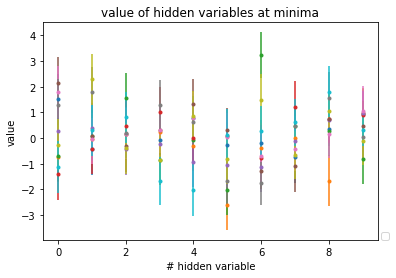

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**do vae on corrupted data with mean of posterior set to MAP values**

---

